In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import matplotlib as mpl

mpl.rcParams['figure.dpi']= 300

In [4]:
import os
import pickle
from PIL import Image

import numpy as np

from transformers import LayoutLMv2Processor

from experiment_utils.constants import *
from experiment_utils.utils import getLogger, get_sample_videos_paths, get_data_path

from csgo_clips_autotrim.feature_extraction import get_downsampled_frames, DownsampleConfig

In [5]:
layoutLM_processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")

In [6]:
def denormalize_bboxes(img, bboxes):
    h, w, _ = img.shape
    x_factor, y_factor = w / 1000, h / 1000
    mult_vec = np.tile(np.array([x_factor, y_factor]), 2)
    
    normalized_bboxes = [bbox * mult_vec for bbox in bboxes[0]]

    return normalized_bboxes

def draw_bbox(img, bboxes):
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    for bbox in denormalize_bboxes(img, bboxes):
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], alpha=0.4)
        ax.add_patch(rect)
    
    plt.show()

In [37]:
frames = get_downsampled_frames((DATA_DIR / 'test_clip_1.mp4').as_posix(), downsample_config=DownsampleConfig.from_str('downsample_1280x720_60_RGB'))

[INFO] 2022-10-01 20:59:26,960 root        : Getting video size for '/code/data/test_clip_1.mp4'
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6317/6317 [00:29<00:00, 214.06it/s]


In [24]:
with open(os.path.join(DATA_DIR, f'test_clip_0_frames.pickle'), 'wb') as f:
    pickle.dump(frames, f)

In [25]:
def try_ocr_on_image(image):
    encoding = layoutLM_processor(image, return_tensors="pt")
    draw_bbox(image, encoding['bbox'])

In [26]:
def try_ocr_on_image_path(image_path):
    image = np.array(Image.open(image_path).convert('RGB'))
    try_ocr_on_image(image)

In [38]:
len(frames)

71

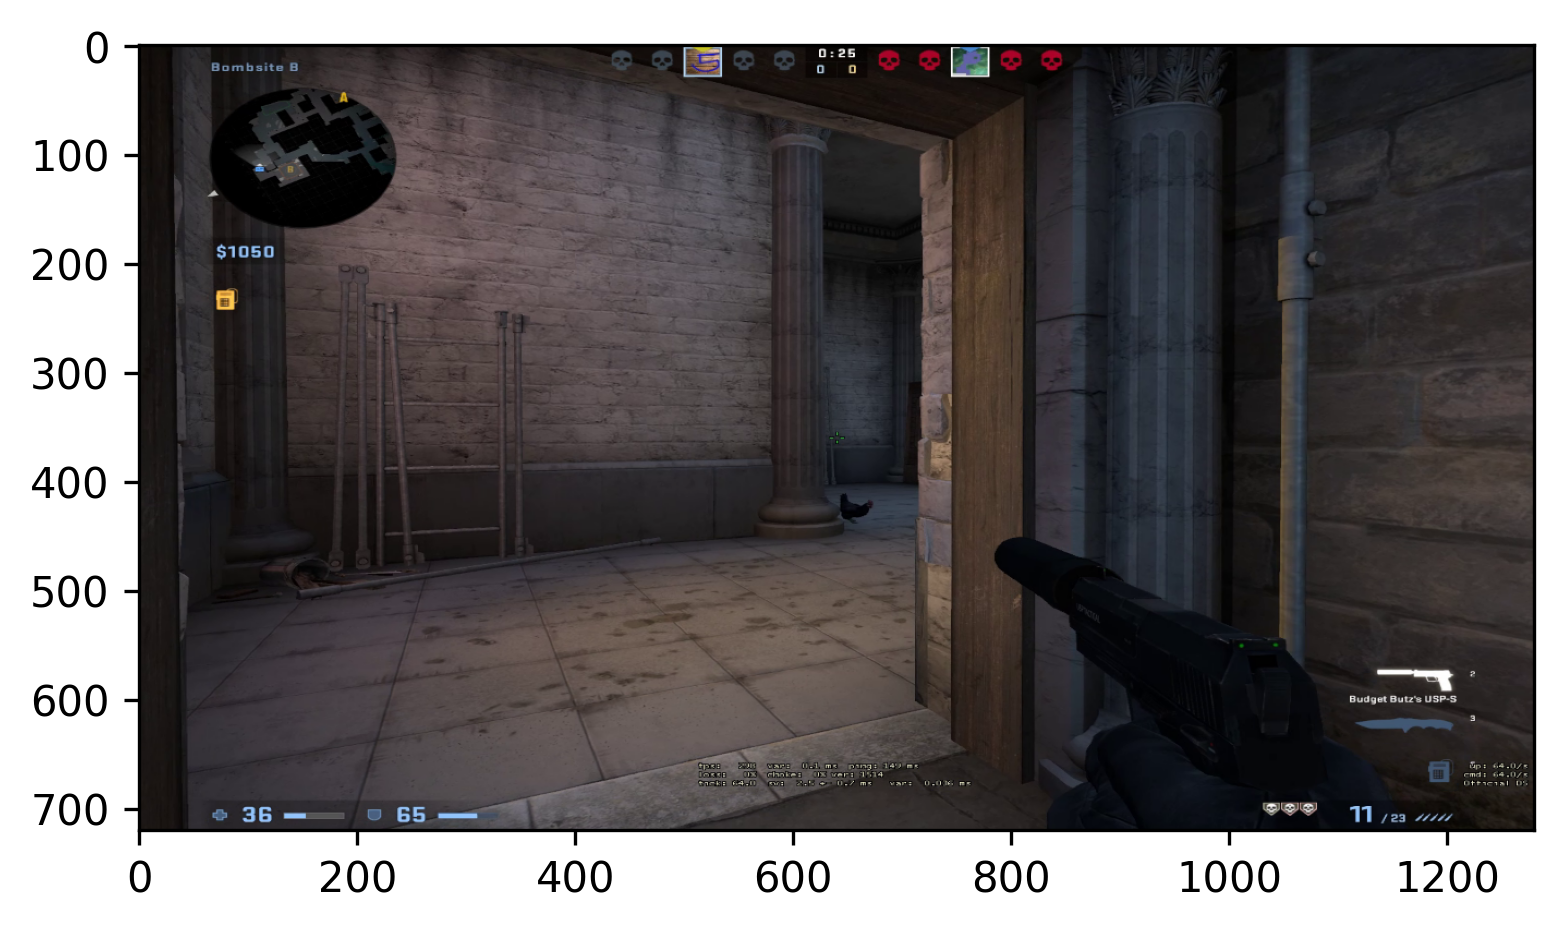

In [40]:
plt.imshow(frames[-1], cmap='gray')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


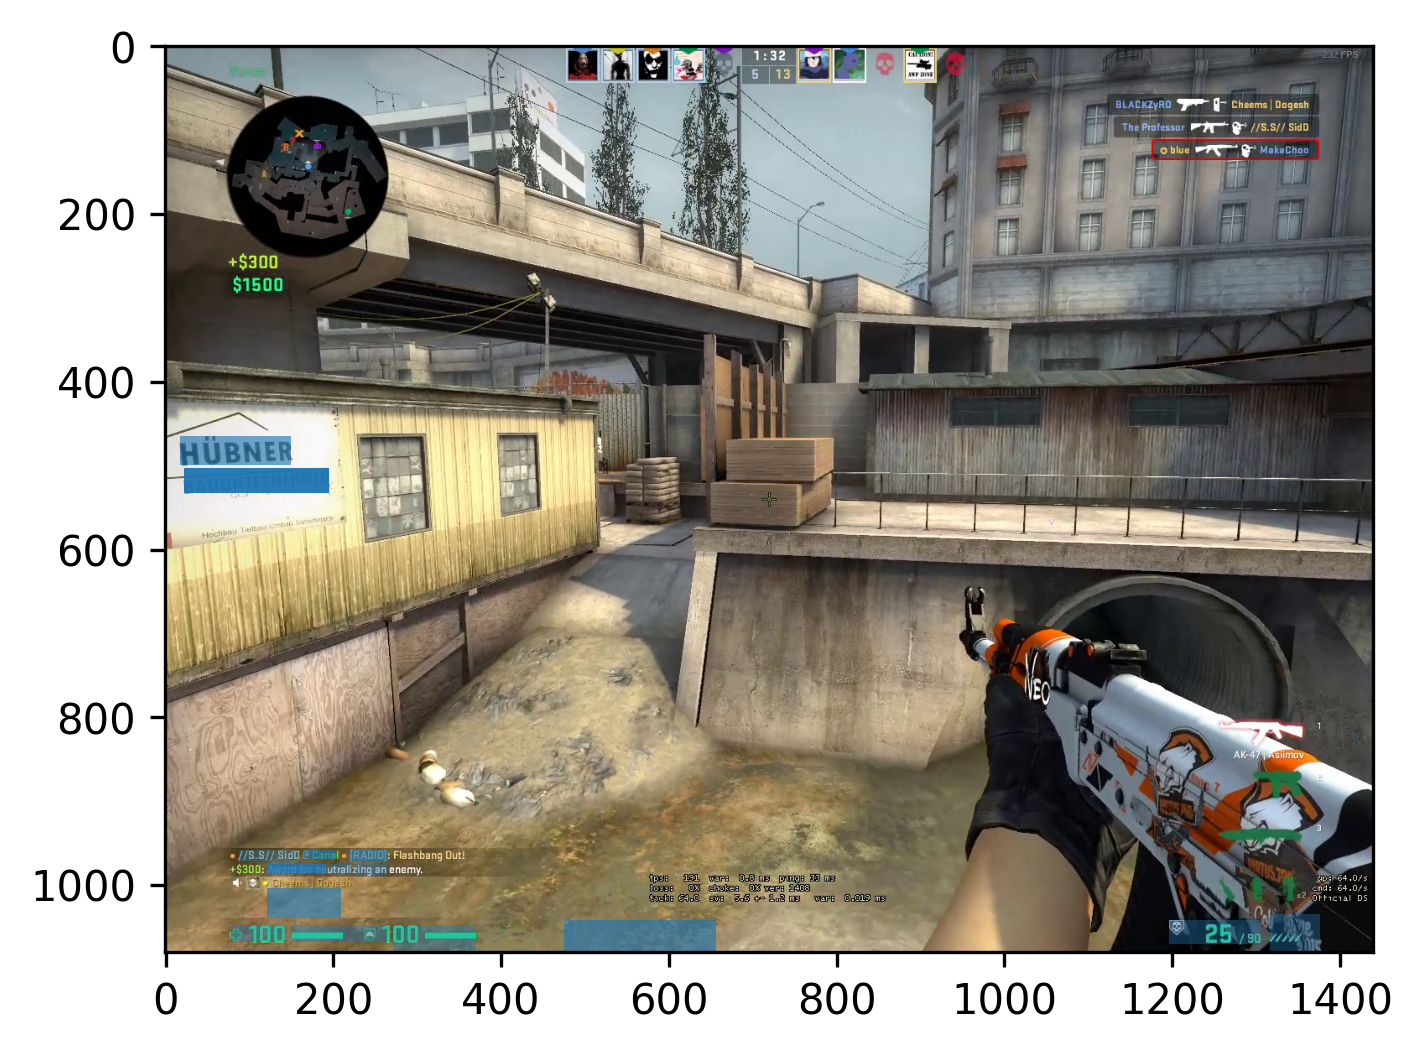

In [118]:
try_ocr(get_data_path(['ocr_test_big_2.png']))

### Trying cv2 transforms to improve OCR perf



In [65]:
import cv2

In [152]:
def preprocess_image(img: np.ndarray):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh_rgb = cv2.merge([thresh, thresh, thresh])
    
    return thresh_rgb

In [153]:
def try_ocr_img(img):
    processed_image = preprocess_image(img)
    encoding = layoutLM_processor(processed_image, return_tensors="pt")
    draw_bbox(processed_image, encoding['bbox'])

In [154]:
image = np.array(Image.open(get_data_path(['ocr_test_big_2.png'])).convert('RGB'))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


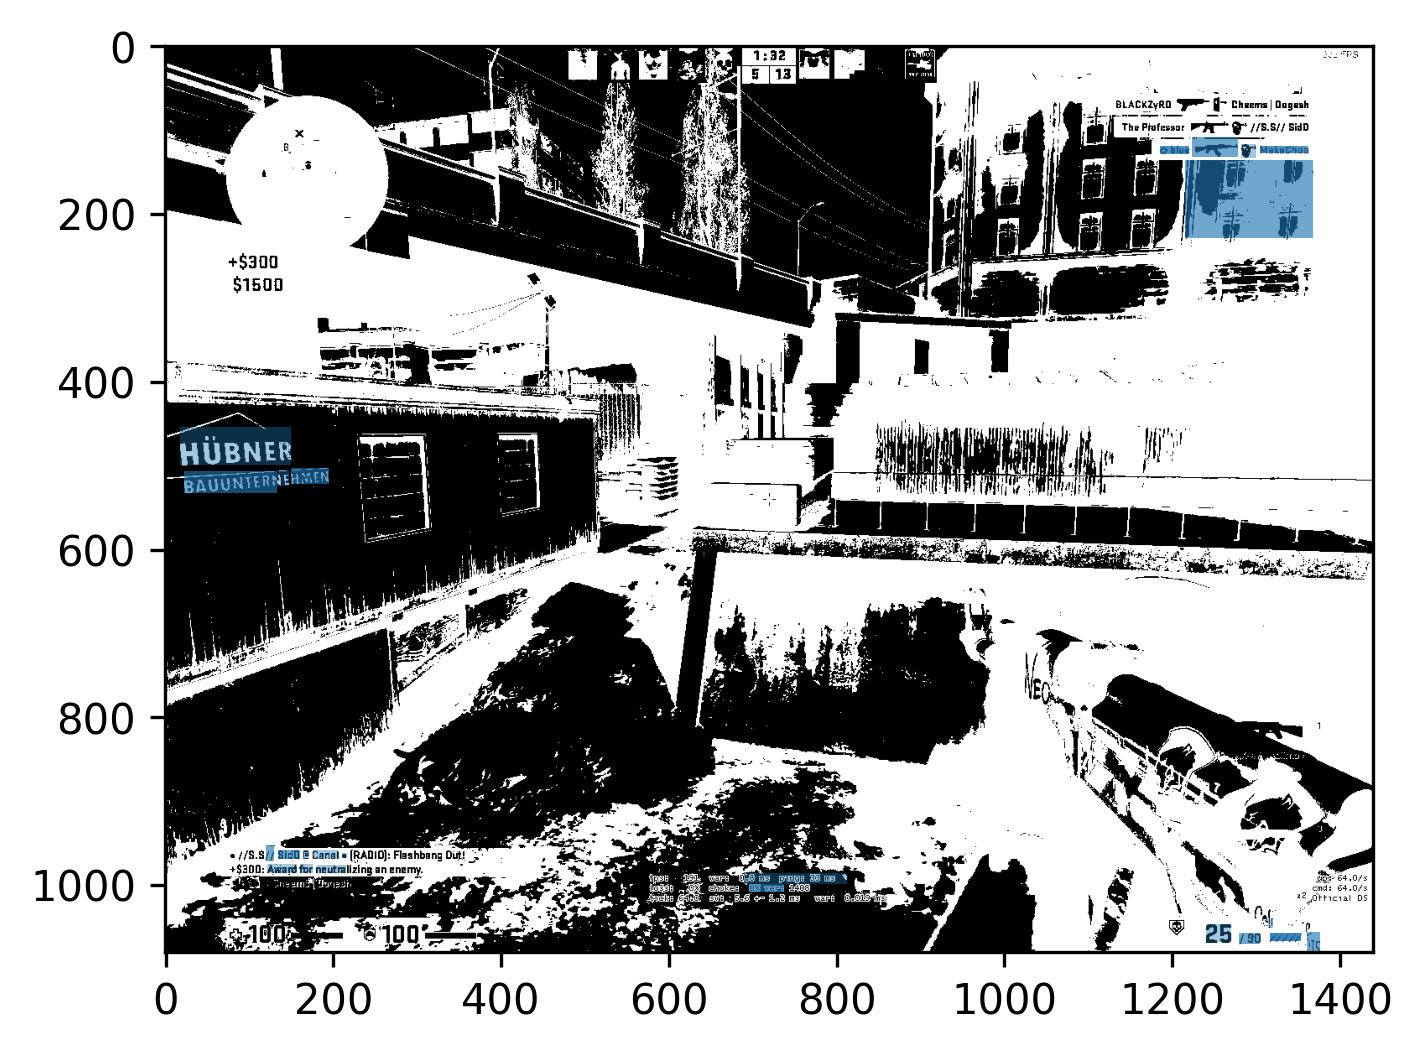

In [155]:
try_ocr_img(image)